# Tilt axis identification

This notebook will show an example of how to identify the tilt axis of a sample holder, by means of a tilt series.

For this, you will need a tilt series of a sample, meaning the same sample scanned (and subsequently orientation mapped) at multiple different tilt angles.

For this tutorial, Orix's example dataset will be used, artificially tilted and with some added noise.
The noise is not meant to emulate the kind of orientation discrepancies expected from a real tilt series, but rather as a way to show a certain level of robustness.

In [1]:
# Import the necessary packages
%matplotlib inline
from matplotlib import pyplot as plt
from orix.vector import Vector3d
import numpy as np

import tiltlib

# 00 Fabricating data

In this section, a tilt series is fabricated from one of Orix's example datasets.

If you have your own tilt series, you can skip this section.

The fabricated data is tilted around an axis lying in the xy-plane, rotated 30 degrees from the x-axis.
Noise is introduced to each map, in the form of an additional rotation of large magnitude for some pixels (speckling) and low magnitude for all pixels.

In [12]:
# Make some fake tilt series data
from orix.quaternion import Rotation
from orix.data import sdss_austenite

np.random.seed(10)

# This is the raw data we will use
raw_xmap = sdss_austenite(allow_download=True)

# Arbitrarily choose the tilt axis direction. Should lie in or close to the xy-plane
# Here, we use the x-axis, rotated 50 degrees around z
axis_direction = Vector3d.xvector().rotate(Vector3d.zvector(), np.deg2rad(30))

# Choose a couple tilt angles
tilt_angles = [0, -10, 5, 15] # degrees

# Make a couple xmaps at the different tilt angles
xmaps = [raw_xmap.deepcopy() for _ in tilt_angles]
for xmap, tilt_angle in zip(xmaps, tilt_angles):

    # Manually modify the rotations with a rotation
    xmap._rotations[...] *= ~Rotation.from_axes_angles(axis_direction, tilt_angle, degrees=True)

    # Add some pixel noise to every scan, at different intervals
    s = slice(None, None, np.random.randint(4, 10))
    xmap._rotations[s] *= Rotation.random(xmap._rotations.shape)[s]

    # Introduce a slight variance to all pixels, with euler angles between -2 to 2 degrees
    euler = np.vstack([
        np.random.uniform(-2, 2, xmap._rotations.size),
        np.random.uniform(-2, 2, xmap._rotations.size),
        np.random.uniform(-2, 2, xmap._rotations.size),
    ]).T
    xmap._rotations[...] *= Rotation.from_euler(euler, degrees=True).reshape(*xmap._rotations.shape)

(-0.5, 116.5, 99.5, -0.5)

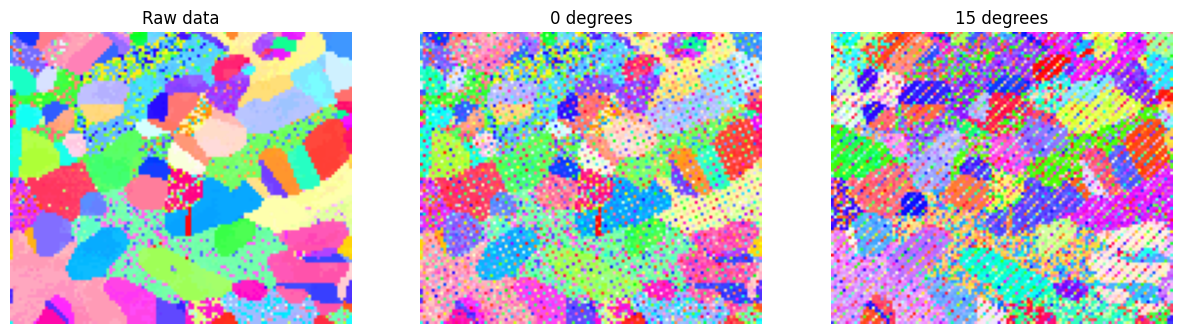

In [18]:
# Show the difference between the raw crystal map and the noisy tilt series
from orix.plot import IPFColorKeyTSL
key = IPFColorKeyTSL(raw_xmap.phases[0].point_group)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(key.orientation2color(Rotation.from_euler(raw_xmap.get_map_data("orientations"), degrees=False)))
plt.title("Raw data")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(key.orientation2color(Rotation.from_euler(xmaps[0].get_map_data("orientations"), degrees=False)))
plt.title("0 degrees")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(key.orientation2color(Rotation.from_euler(xmaps[-1].get_map_data("orientations"), degrees=False)))
plt.title("15 degrees")
plt.axis("off")

# 01 Load your data

In this section, you can load your data.

You need a couple `CrystalMap`s and the tilt angles at which the data was captured at.

In [ ]:
# Depending on how you saved your data, other loading methods might be more suitable
from orix.io import load

xmaps = [
    load("path_to_your_data/xmap_1.h5"),
    load("path_to_your_data/xmap_2.h5"),
    load("path_to_your_data/xmap_3.h5"),
    load("path_to_your_data/xmap_4.h5"),
    ]
tilt_angles = [0, 5, 10, 15] # degrees

The tilt angles do not need to be in order, but the order must correspond to the order of the crystal maps.


# 02 Fitness function

To find which axis angle fits best, we need to quantify the fitness of an axis position.
Here, we choose a metric based on finding the mean misorientation angle between scans, after tilting them all to 0 degrees around a given tilt axis.
All pixels of all scans are compared across all possible combinations of scans.
As a tilt physically moves the sample, the sample is not completely lined up pixel-wise for all combinations.
If possible, the user should crop their data such that it lines up as good as possible.
An imperfect alignment of the scans is also fine, since only the lowest 1/3 misorientation angles will be considered for optimization.
This selection mitigates the effects of misalignment, misindexation, and specling.

This fitness function is quite robust, as it compares all pixels throughout the entire scan, for all possible combinations of scans.
However, this makes it rather slow.
Other fitness functions may provide faster computations.

In [4]:
from itertools import combinations

def fitness(axis_angle: float):
    # Note the single input angle, as we assume the axis lies in the xy-plane, perpendicular to the optical axis.

    axis_direction = Vector3d.xvector().rotate(Vector3d.zvector(), np.deg2rad(axis_angle))

    samples: list[tiltlib.Sample] = []
    for xmap, angle in zip(xmaps, tilt_angles):
        s = tiltlib.Sample(xmap, [tiltlib.Axis(axis_direction, -30, 30, angle=angle, degrees=True)])
        s.rotate_to(0)
        samples.append(s)

    misorientation_angles = []
    
    for sample_a, sample_b in combinations(samples, 2):
        misorientation_angles.append(sample_a.orientations.angle_with(sample_b.orientations, degrees=True))
    misorientation_angles = np.array(misorientation_angles).flatten()
    
    # Choose the bottom third misorientation angles, as most of the large angles are probably due to noise / misindexation
    k = misorientation_angles.size // 3
    return np.mean(np.partition(misorientation_angles, k, axis=None)[:k])


# 03 Performing the optimization
At this point, using e.g. `scipy.optimize.minimize` should yield the tilt axis position.
Additionally, we make a plot of the fitness score along a full rotation of axis positions, to show that the minima is indeed global.

In [14]:
from scipy.optimize import minimize

res = minimize(
    fitness,
    0,
    bounds=((-180, 180),),
)
res

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 1.4922734583189576
        x: [ 2.999e+01]
      nit: 7
      jac: [ 2.554e-06]
     nfev: 22
     njev: 11
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

100%|██████████| 180/180 [07:09<00:00,  2.39s/it]


Text(0, 0.5, 'Score')

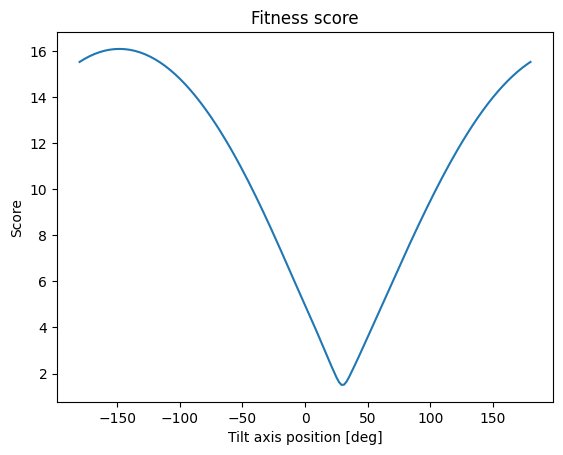

In [15]:
# We use tqdm to get a nice progress bar, as this is quite slow
from tqdm import tqdm

angles = np.linspace(-180, 180, 180)
fitness_scores = [fitness(ang) for ang in tqdm(angles)]

plt.figure()
plt.title("Fitness score")
plt.plot(angles, fitness_scores)
plt.xlabel("Tilt axis position [deg]")
plt.ylabel("Score")

From both the optimization and from manually inspecting the graph, we see the angle of the tilt axis with the x-axis is 30 degrees, as we set it to initially.